### Import Libraries

In [1]:
# pandas to handle csv
import pandas as pd
# numpy to handle array
import numpy as np
# standard scaler to normalize the dataset
from sklearn.preprocessing import StandardScaler
# seaborn, scikit plot & matplotlib for vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
# train test splitter and grid search cross validation 
from sklearn.model_selection import train_test_split, GridSearchCV
# xgboost classifier
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
from xgboost import XGBClassifier
# random forest classifier
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
# metrics functions
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix

In C:\Users\mfreriks\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\mfreriks\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\mfreriks\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\mfreriks\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor 

### Import Dataset

In [2]:
# read the dataset
dataset = pd.read_csv('Attribute_list_all_features_37.csv')

In [3]:
# drop unwanted columns 
dataset.drop(['Rider_name', 'Date', 'Race_Name', 'Rank', 'RaceStrength', 'RiderStrength', 'Year',
             'last_60_10','last_60_5','last_60_3','last_120_10','last_12_5','last_120_3','last_180_10',
              'last_180_5','last_180_3','last_280_10','last_280_5','last_280_3'], axis=1, inplace=True)
# remove rows with blank cells
dataset.dropna(axis=1, inplace=True)

In [4]:
# display first 5 rows of the dataset
dataset.head()

,Normalized_power,Duration,Stage,Class,max10secpower,SprinterType,FTP,Kilogram,CP,Wprime,...,L3,L4,L5,L6,L7,entire_CP,entire_10,entire_5,entire_3,entire_2
0,303.615022,10878.0,6,HC,1270,Not,409,75.000000,409.122375,17229.173828,...,0.080254,0.058650,0.044585,0.046332,0.033462,1439.0,75.0,147.0,301.0,601.0
1,311.109513,18075.0,3,.1,1270,Not,409,75.000000,409.122375,17229.173828,...,0.122158,0.083707,0.056376,0.062849,0.048465,3391.0,197.0,342.0,619.0,1012.0
2,250.825257,17037.0,4,WT,1306,Not,404,72.500000,387.641785,28797.880859,...,0.087105,0.041557,0.023713,0.019428,0.016904,1307.0,2.0,6.0,11.0,39.0
3,260.632108,11185.0,21,WT,1306,Not,404,72.500000,387.641785,28797.880859,...,0.063388,0.040590,0.028520,0.031381,0.028699,1104.0,0.0,5.0,11.0,26.0
4,262.548986,17579.0,1,HC,1232,Not,403,72.900002,402.595886,31012.943359,...,0.112805,0.070311,0.034871,0.027135,0.015245,1720.0,0.0,0.0,8.0,38.0


### Feature Engineering

In [5]:
# convert categorical features 
dataset = pd.get_dummies(dataset,columns=['Class','SprinterType'])

# change succes to integers
dataset.loc[(dataset.Succes == 'Succesfull'), 'Succes'] = 1
dataset.loc[(dataset.Succes == 'Non-succesfull'), 'Succes'] = 0
dataset.loc[(dataset.Succes == 'Failure'), 'Succes'] = 0
# set the datatype of succes columns to numeric
dataset['Succes'] = pd.to_numeric(dataset['Succes']) 

In [6]:
# create feature dataset
feature_dataset  = dataset[['Normalized_power', 'Duration', 'Stage', 'max10secpower', 'FTP',
       'Kilogram', 'CP', 'Wprime', 'power_mean', 'TSS', 'Count',
       'CumSum', 'Count10', 'Count30', 'Count60', 'CumSumAbsolute',
       'SSDAboveCP', 'SSD', 'Var', 'Skew', 'Kurtosis', 'WpCount',
       'WpDischarge', 'L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'entire_CP',
       'entire_10', 'entire_5', 'entire_3', 'entire_2', 'Class_.1', 'Class_HC',
       'Class_WT', 'SprinterType_Medium', 'SprinterType_Not',
       'SprinterType_Sprinter']].copy()

In [7]:
# create target dataset
target = dataset[['Succes']].copy()

### Feature Selection

Text(0.5, 1.0, 'Correlation HeatMap')

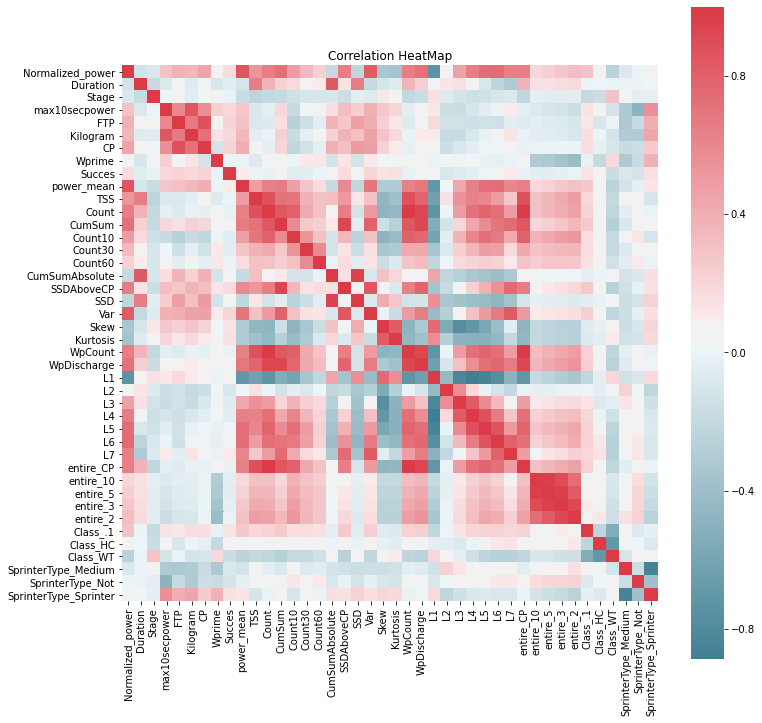

In [8]:
# create a correlation heatmap to understand the correlation of features to target
# any high correlation features can be removed to see if any accuracy improvement happens to the models
f, ax = plt.subplots(figsize=(12, 12))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.title('Correlation HeatMap')

Target(Succes) doesn't have any high correlation with features present in the data. Hence proceeding with scaling and modeling

### Feature Scaling

In [21]:
# create feature array/dataframe
# Normalize the dataset so that the algorithm can be trained easily
X = pd.DataFrame(StandardScaler().fit_transform(feature_dataset))
X.columns = feature_dataset.columns

# create target array
y = target.values.ravel()

### Train Test Split

In [22]:
# reserve 33% of data for testing
# random state is set inorder to regenrate the same result in every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### XGBoost Classifier

#### Grid Search and Cross Validation

In [23]:
# a function to define the gridsearch inorder to get the best fit model with optimized parameters
# function return the best fit optimized model
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
def gridsearchfn(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='accuracy'):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    return fitted_model

In [24]:
# define xgboost classifier with random state as model. 
model = XGBClassifier(random_state=42)

# parameter grid is defined inorder to search through and get the best fit parameters
param_grid = {
    'max_depth': [5,10,15,20,25,30,35,40,45,50],
    'eta': [0.001, 0.01, 0.1, 1],
    'gamma': [0, 0.1 , 1, 2, 5]
}

# invoke the gridsearch function to get the best fit model and parameters
model = gridsearchfn(X_train, X_test, y_train, y_test, model, param_grid, cv=3)

# print the best parameters
print('Best Parameters : ', model.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.9s


Best Parameters :  {'eta': 0.01, 'gamma': 0, 'max_depth': 10}


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   10.2s finished


#### Model Finalization

In [25]:
# Best Parameters :  {'eta': 0.01, 'gamma': 0, 'max_depth': 10}
# define the model with best parameters from grid search cross validation
xgbclf = XGBClassifier(eta= 0.01, gamma= 0, max_depth= 10, random_state=0)
xgbclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00999999978, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Train Data Metrics

Text(0.5, 1.0, 'Train Data Confusion Matrix - XGBoost')

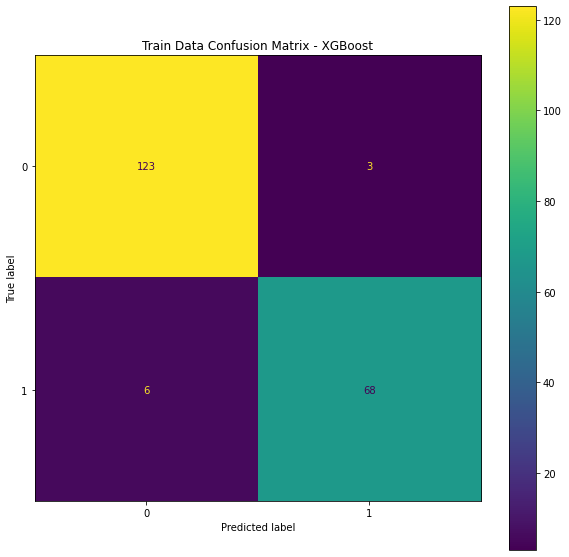

In [26]:
# plot the confusion matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
plt.rcParams["figure.figsize"] = (10,10)
plot_confusion_matrix(xgbclf, X_train, y_train)
plt.title('Train Data Confusion Matrix - XGBoost')

In [27]:
# generate perfomance report with f1 score, precision, accuracy  and recall parameters
y_pred = xgbclf.predict(X_train)
print ('Train Data Perfomance Details')
print (classification_report(y_train, y_pred))

Train Data Perfomance Details
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       126
           1       0.96      0.92      0.94        74

    accuracy                           0.95       200
   macro avg       0.96      0.95      0.95       200
weighted avg       0.96      0.95      0.95       200



#### Test Data Metrics

Text(0.5, 1.0, 'Test Data Confusion Matrix - XGBoost')

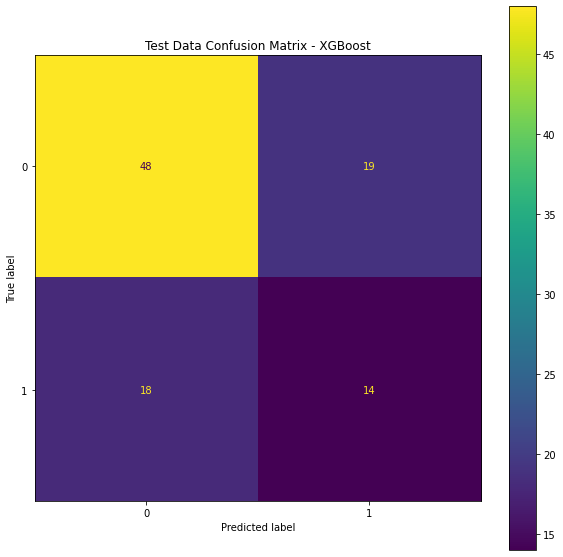

In [28]:
# plot the confusion matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
plt.rcParams["figure.figsize"] = (10,10)
plot_confusion_matrix(xgbclf, X_test, y_test)
plt.title('Test Data Confusion Matrix - XGBoost')

In [29]:
# generate perfomance report with f1 score, precision, accuracy  and recall parameters
print ('Test Data Perfomance Details')
y_pred = xgbclf.predict(X_test)
xgbclf_acc_score = accuracy_score(y_test, y_pred)
print (classification_report(y_test, y_pred))

Test Data Perfomance Details
              precision    recall  f1-score   support

           0       0.73      0.72      0.72        67
           1       0.42      0.44      0.43        32

    accuracy                           0.63        99
   macro avg       0.58      0.58      0.58        99
weighted avg       0.63      0.63      0.63        99



####  Test Data ROC Curve

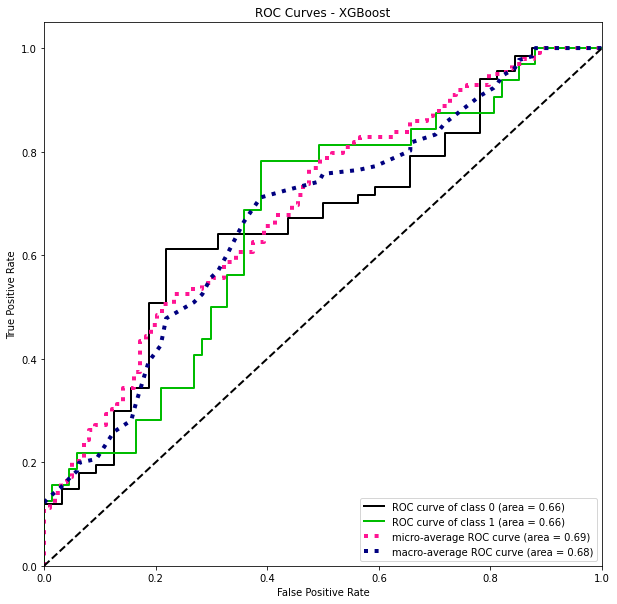

In [30]:
# plot roc curve for test data
# https://libraries.io/pypi/scikit-plot
y_true = y_test
y_probas = xgbclf.predict_proba(X_test)
plt.rcParams["figure.figsize"] = (10,10)
skplt.metrics.plot_roc(y_true, y_probas)
plt.title('ROC Curves - XGBoost')
plt.show()

#### Feature Importance - XGBoost

Text(0.5, 1.0, 'Feature Importance - XGBoost')

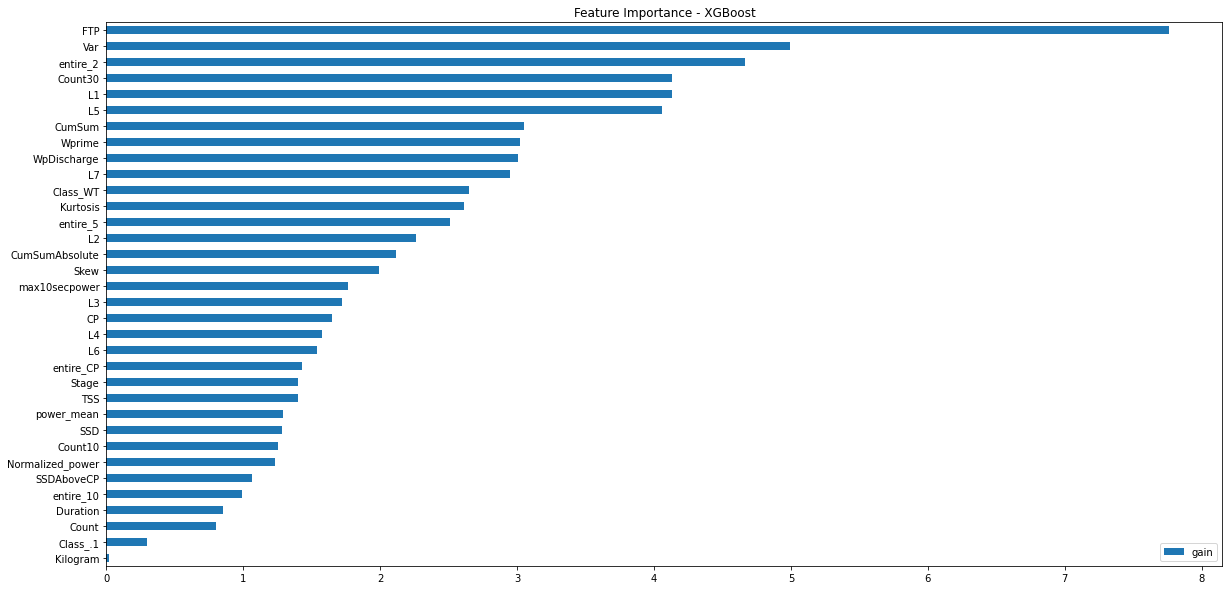

In [31]:
# extract the feature importance data from the model
feat_imp_df = pd.DataFrame(xgbclf.get_booster().get_score( importance_type='gain'), index=[0]).T
feat_imp_df.columns = ['gain']
feat_imp_df.sort_values(by='gain', inplace=True)

# create a hroizontal bar plot to vizualise the feature importance
plt.rcParams["figure.figsize"] = (20,10)
feat_imp_df.plot.barh()
plt.title('Feature Importance - XGBoost')

### Random Forest Classifier

#### Grid Search and Cross Validation

In [33]:
# define xgboost classifier with random state as 42 as model. 
model = RandomForestClassifier(random_state=42)

# parameter grid is defined inorder to search through and get the best fit parameters
param_grid = {
    'n_estimators': [10,20,40,60,120,240,480,960]
}

# invoke the gridsearch function to get the best fit model and parameters
model = gridsearchfn(X_train, X_test, y_train, y_test, model, param_grid, cv=5)

print('Best Parameters : ', model.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.8s


Best Parameters :  {'n_estimators': 60}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.1s finished


#### Model Finalization

In [34]:
# Best Parameters :  {'n_estimators': 60}
rndfclf = XGBClassifier(n_estimators= 60, random_state=42)
rndfclf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

#### Train Data Metrics

Text(0.5, 1.0, 'Train Data Confusion Matrix - Random Forest')

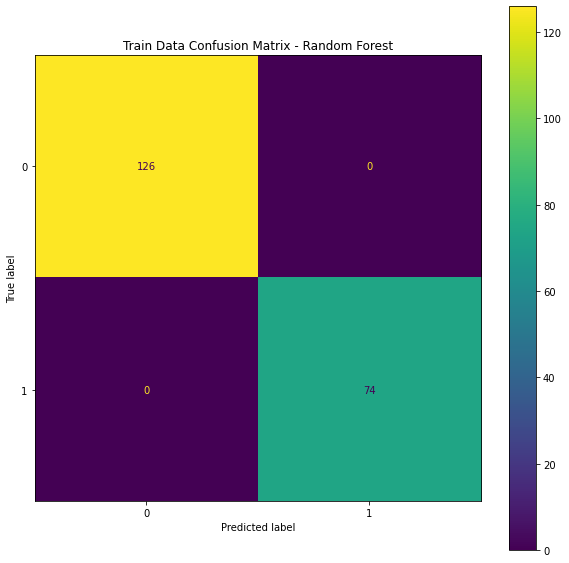

In [35]:
# plot the confusion matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
plt.rcParams["figure.figsize"] = (10,10)
plot_confusion_matrix(rndfclf, X_train, y_train)
plt.title('Train Data Confusion Matrix - Random Forest')

In [36]:
# generate perfomance report with f1 score, precision, accuracy  and recall parameters
y_pred = rndfclf.predict(X_train)
print ('Train Data Perfomance Details')
print (classification_report(y_train, y_pred))

Train Data Perfomance Details
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       126
           1       1.00      1.00      1.00        74

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



#### Test Data Metrics

Text(0.5, 1.0, 'Test Data Confusion Matrix - Random Forest')

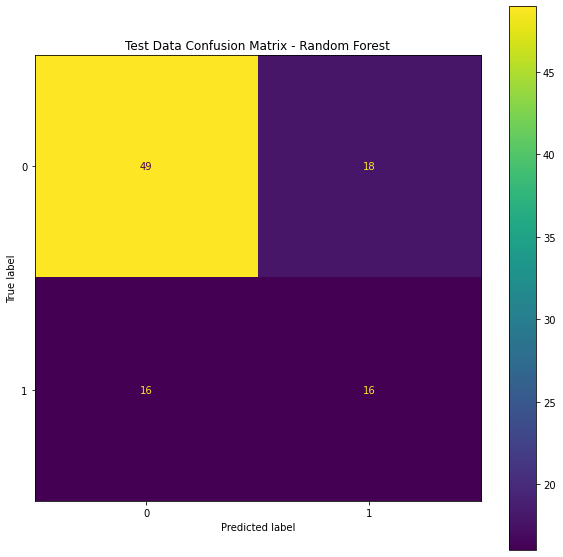

In [37]:
# plot the confusion matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
plt.rcParams["figure.figsize"] = (10,10)
plot_confusion_matrix(rndfclf, X_test, y_test)
plt.title('Test Data Confusion Matrix - Random Forest')

In [38]:
# generate perfomance report with f1 score, precision, accuracy  and recall parameters
print ('Test Data Perfomance Details')
y_pred = rndfclf.predict(X_test)
rndf_acc_score = accuracy_score(y_test, y_pred)
print (classification_report(y_test, y_pred))

Test Data Perfomance Details
              precision    recall  f1-score   support

           0       0.75      0.73      0.74        67
           1       0.47      0.50      0.48        32

    accuracy                           0.66        99
   macro avg       0.61      0.62      0.61        99
weighted avg       0.66      0.66      0.66        99



####  Test Data ROC Curve

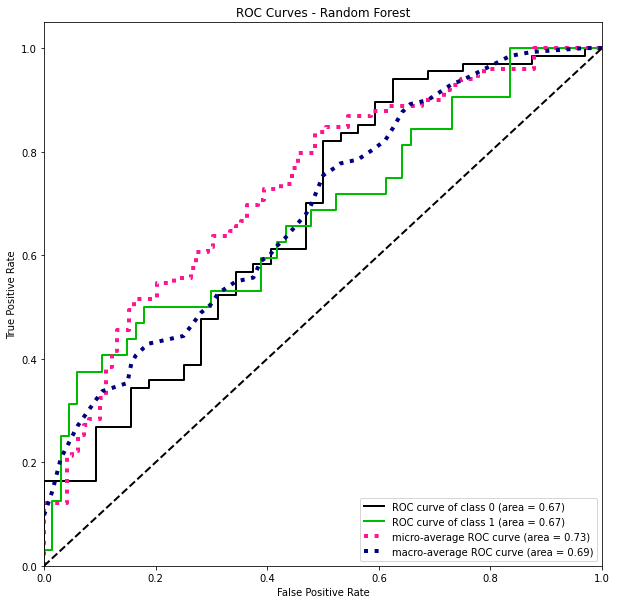

In [39]:
# plot roc curve for test data
# https://libraries.io/pypi/scikit-plot
y_true = y_test
y_probas = rndfclf.predict_proba(X_test)
plt.rcParams["figure.figsize"] = (10,10)
skplt.metrics.plot_roc(y_true, y_probas)
plt.title('ROC Curves - Random Forest')
plt.show()

#### Feature Importance - Random Forest

Text(0.5, 1.0, 'Feature Importance - Random Forest')

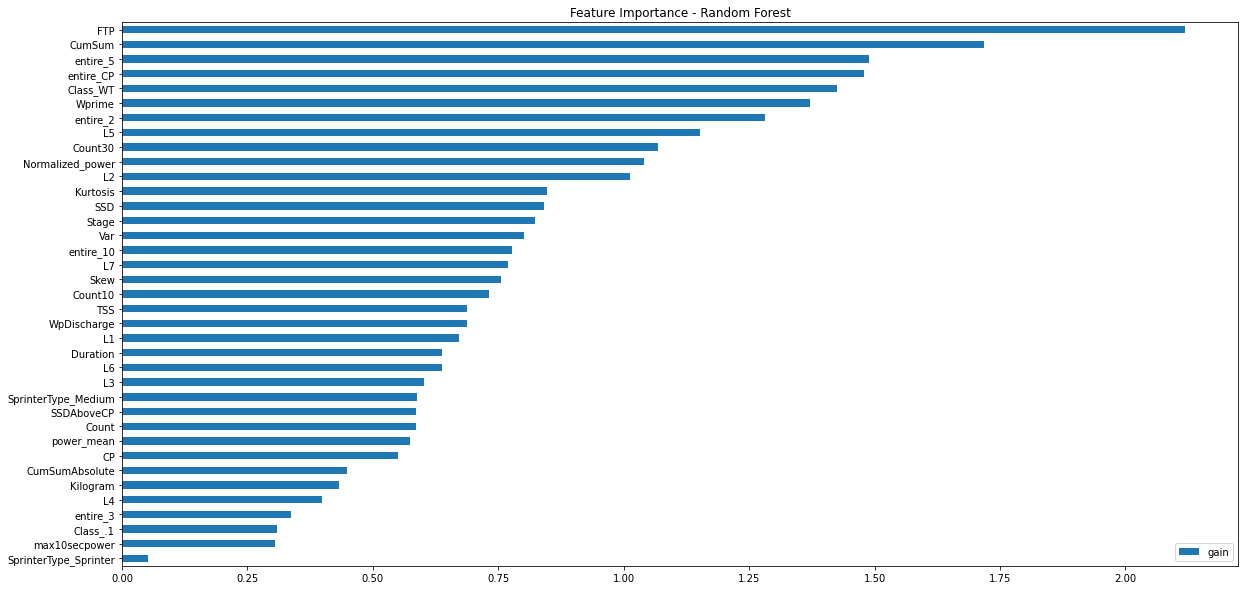

In [40]:
# extract the feature importance data from the model
feat_imp_df = pd.DataFrame(rndfclf.get_booster().get_score( importance_type='gain'), index=[0]).T
feat_imp_df.columns = ['gain']
feat_imp_df.sort_values(by='gain', inplace=True)

# create a hroizontal bar plot to vizualise the feature importance
plt.rcParams["figure.figsize"] = (20,10)
feat_imp_df.plot.barh()
plt.title('Feature Importance - Random Forest')

### Highest Feature Importance Factor (FTP) and Success

Text(0, 0.5, 'Occurance')

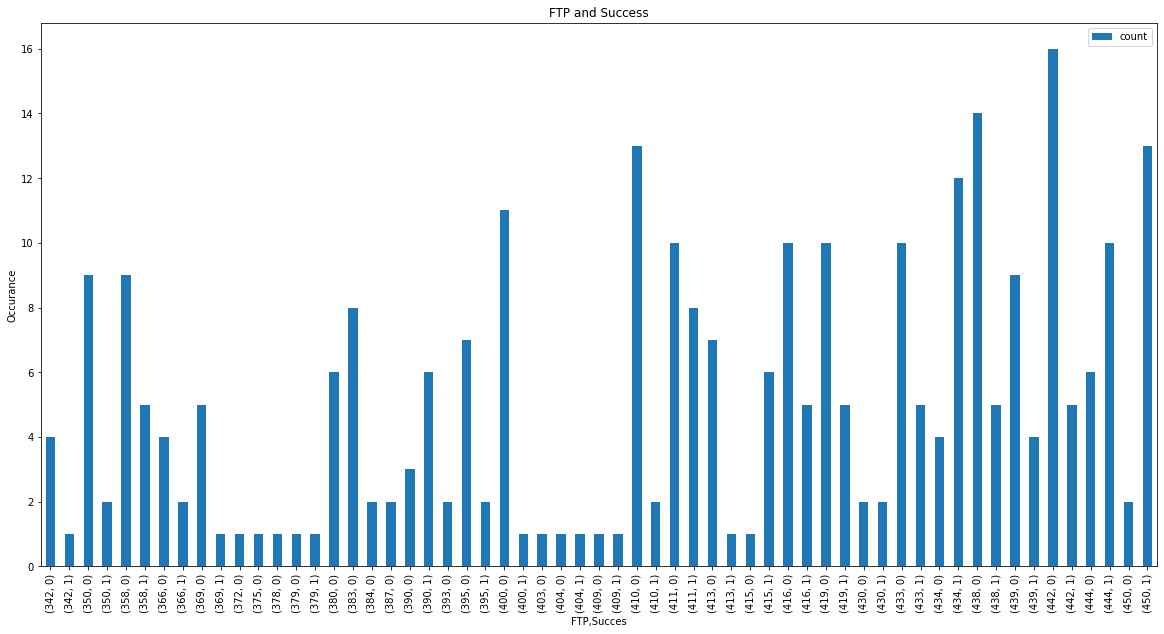

In [41]:
# generate a grouped data inorder to establish a relation between FTP and occurace of success
graph_df = dataset[['FTP', 'Succes']].copy()
graph_df['count'] = 1
data_df = graph_df.groupby(['FTP', 'Succes']).sum()
data_df.to_csv('FTP and Success.csv')
plt.rcParams["figure.figsize"] = (20,10)
data_df.plot.bar()
plt.title('FTP and Success')
plt.ylabel('Occurance')

Failure tends to happen alot with FTP 442, 438, 410, 400. Success tends to happen a lot with FTP 450, 434.

### Accuracy Comparison

0.6767676767676768 0.32323232323232326 0.6262626262626263 0.6565656565656566


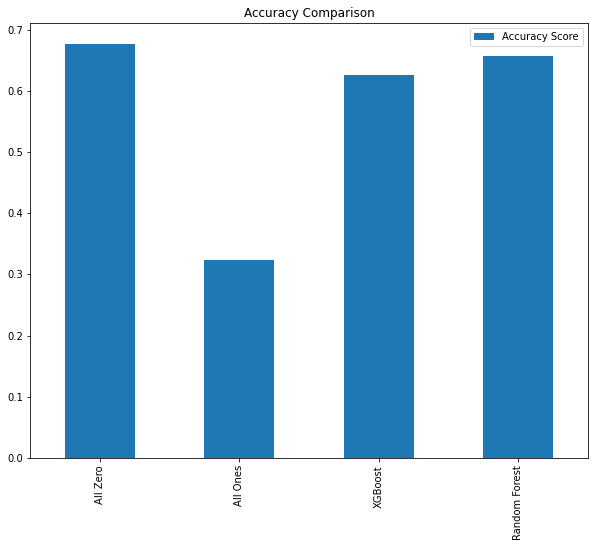

In [42]:
# generate a accuracy comparison plot for the model defined above and two benchmark scenarios (all zeroes and all ones)
y_pred = np.zeros(y_test.shape)
all_zero_acc = accuracy_score(y_test, y_pred)
y_pred = np.ones(y_test.shape)
all_ones_acc = accuracy_score(y_test, y_pred)
arr_dict = {'All Zero': all_zero_acc, 
        'All Ones': all_ones_acc, 
        'XGBoost': xgbclf_acc_score, 
        'Random Forest': rndf_acc_score}
acc_cmp_df = pd.DataFrame(arr_dict, index=[0]).T
acc_cmp_df.columns = ['Accuracy Score']
plt.rcParams["figure.figsize"] = (10,8)
acc_cmp_df.plot.bar()
plt.title('Accuracy Comparison')
print(all_zero_acc,all_ones_acc,xgbclf_acc_score,rndf_acc_score)

### Conclusion

XGBoost was found to be 63% accurate on test data.
Random Forest was found to be 66% accurate on test data. Hence Random Forest can be suggested as an optimal model.
